In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from src.data.datasets import ModelParamsDataset

from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.model.models import DBModel, VAE

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from src.visualization.visualize import plot_decision_boundary

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [2]:
# Hyperparameters
epochs = 100
kdl_weight = 1
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 16
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = VAE(latent_dim, dropout)
autoencoder.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../data/eight_angles_small.csv")
train_indices, test_indices, _, _ = train_test_split(range(len(dataset)), dataset.angles, stratify=dataset.angles, test_size=0.2, random_state=random_seed)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Locations
path = "../models/autoencoders/vae_mseloss"
model_path = "{}/model_kdl{}.pth".format(path, kdl_weight)

In [3]:
def loss_fn(x, x_hat, mean, log_var, kdl_weight=40):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + kdl_weight*KLD

## Train

In [4]:
autoencoder.train()
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in train_dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        reconstructed, mean, logvar = autoencoder(parameters_batch)

        optimizer.zero_grad()
        loss = loss_fn(parameters_batch, reconstructed, mean, logvar, kdl_weight)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
    
    print(f"Epoch {epoch} - Loss: {total_loss}")
    if(epoch % 5 == 0):
        torch.save(autoencoder.state_dict(), f"{path}/checkpoint_{epoch}.pth")

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - Loss: 8820124.758789062
Epoch 1 - Loss: 7550439.1767578125
Epoch 2 - Loss: 7103741.640625
Epoch 3 - Loss: 6841026.369140625
Epoch 4 - Loss: 6681900.7392578125
Epoch 5 - Loss: 6554744.9580078125
Epoch 6 - Loss: 6457740.61328125
Epoch 7 - Loss: 6380807.228515625
Epoch 8 - Loss: 6303540.005859375
Epoch 9 - Loss: 6239407.2138671875
Epoch 10 - Loss: 6181755.8408203125
Epoch 11 - Loss: 6134895.5224609375
Epoch 12 - Loss: 6086977.2880859375
Epoch 13 - Loss: 6050273.46484375
Epoch 14 - Loss: 6000282.5478515625
Epoch 15 - Loss: 5971930.1572265625
Epoch 16 - Loss: 5948323.6171875
Epoch 17 - Loss: 5907583.400390625
Epoch 18 - Loss: 5875026.296875
Epoch 19 - Loss: 5851223.951171875
Epoch 20 - Loss: 5822861.5439453125
Epoch 21 - Loss: 5807576.85546875
Epoch 22 - Loss: 5770794.7802734375
Epoch 23 - Loss: 5761694.59765625
Epoch 24 - Loss: 5736561.4111328125
Epoch 25 - Loss: 5710272.3330078125
Epoch 26 - Loss: 5691615.170410156
Epoch 27 - Loss: 5671300.8798828125
Epoch 28 - Loss: 5656726.187

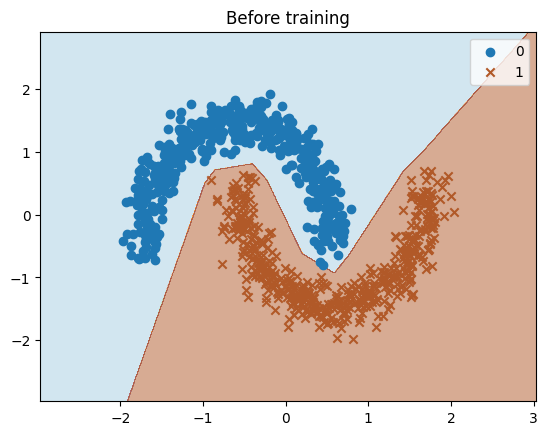

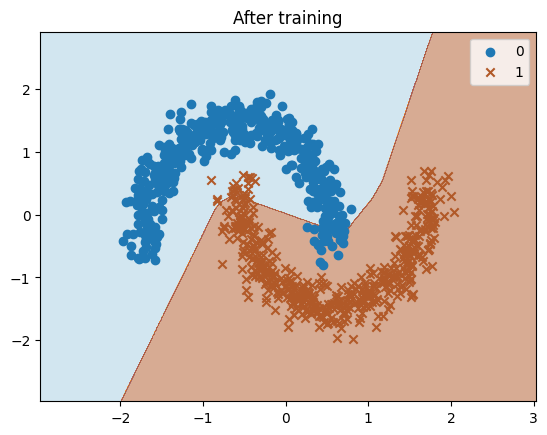

In [5]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

index = 0


parameters = dataset[index][0]
reconstructed, _, _ = autoencoder(parameters.unsqueeze(0))
reconstructed = reconstructed.squeeze()
X, y = get_moons_dataset()
plot_decision_boundary(parameters, X, y, title="Before training")
plot_decision_boundary(reconstructed, X, y, title="After training")

## Latent Space

(80000, 16)
(80000, 3)


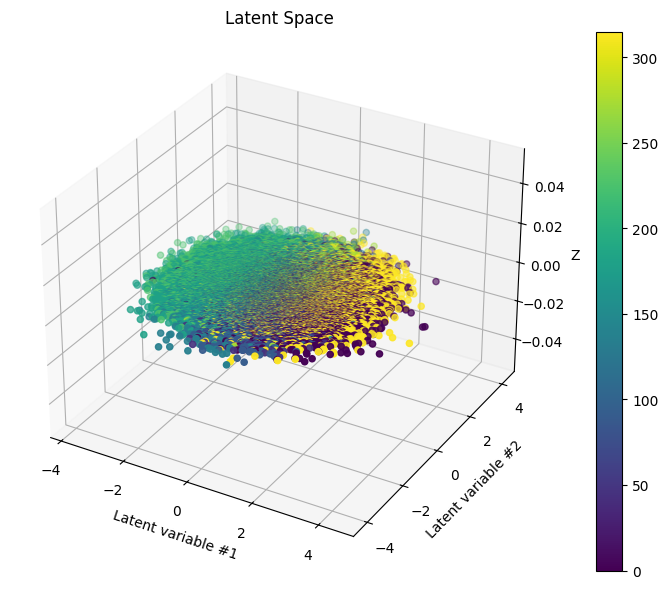

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

weights = torch.tensor(weights).float()
latent, mean, logvar = autoencoder(weights)
latent = autoencoder.reparameterize(mean, logvar).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


plt.title("Latent Space")
plt.xlabel("Latent variable #1")
plt.ylabel("Latent variable #2")
plt.show()

## Reconstructed weights distribution

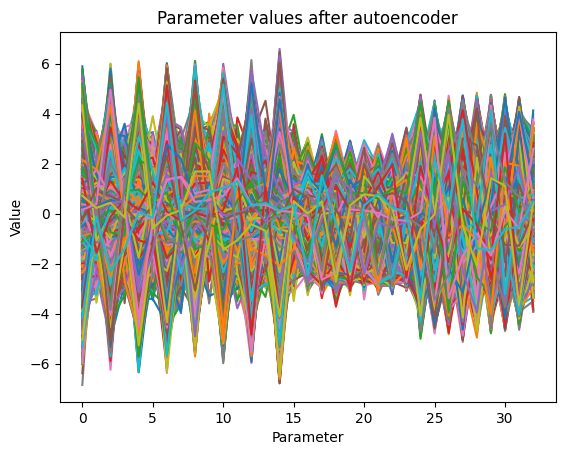

In [20]:
from matplotlib import pyplot as plt

model = VAE(latent_dim, dropout)
model.load_state_dict(torch.load(model_path))
model.eval()

reconstruction = []
for i in range(10000):
    parameters = dataset[i][0].unsqueeze(0)
    r, _, _ = model(parameters)
    r = r.squeeze().detach().numpy()
    reconstruction.append(r)


for r in reconstruction:
    plt.plot(r)

plt.xlabel("Parameter")
plt.ylabel("Value")
plt.title("Parameter values after autoencoder")
plt.show()

## Accuracy distribution

  0%|          | 0/80000 [00:00<?, ?it/s]

Mean trained accuracy: 99.87490625000002
Mean reconstructed accuracy: 89.57693375


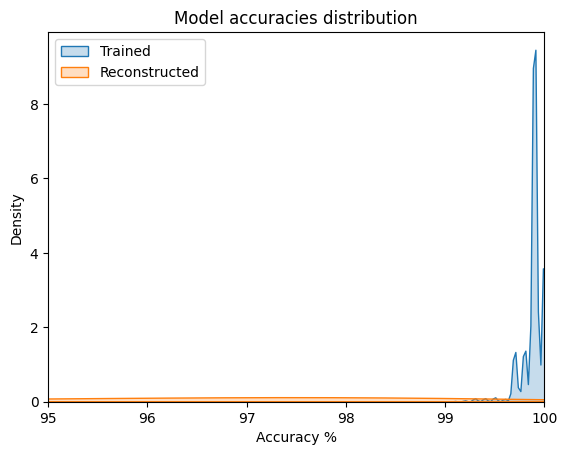

In [21]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/eight_angles_small.csv")

trained_accuracies = []
reconstructed_accuracies = []

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(dataset):
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)

    accuracy = get_accuracy(parameter, X_rotated, y)
    trained_accuracies.append(accuracy)

    reconstructed, _, _ = autoencoder(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    accuracy = get_accuracy(reconstructed, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean reconstructed accuracy: {np.mean(reconstructed_accuracies)}")

sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.xlim(95, 100)
plt.show()


## Interpolation

  0%|          | 0/7 [00:00<?, ?it/s]

Mean interpolation accuracy: 76.30077


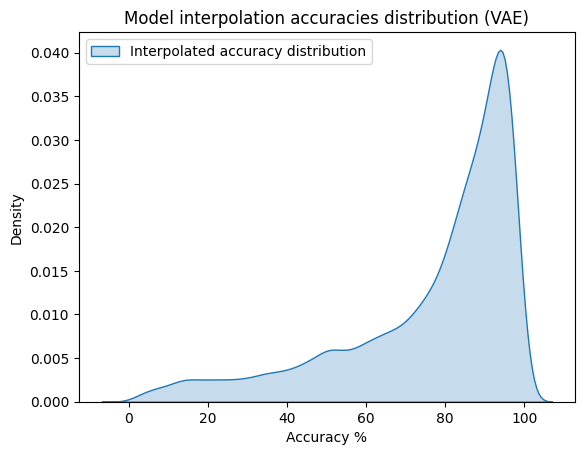

In [22]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []
bad_accuracy = []

for i in tqdm(range(0, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)

        latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        mean = autoencoder.mu(latent)
        logvar = autoencoder.logvar(latent)
        latent = autoencoder.reparameterize(mean, logvar)

        w = autoencoder.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        # if(accuracy < 50):
        #     print(i)
        #     print(i+1)
        #     print(j)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model interpolation accuracies distribution (VAE)")
plt.xlabel("Accuracy %")
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

Mean interpolation accuracy: 76.41425714285714


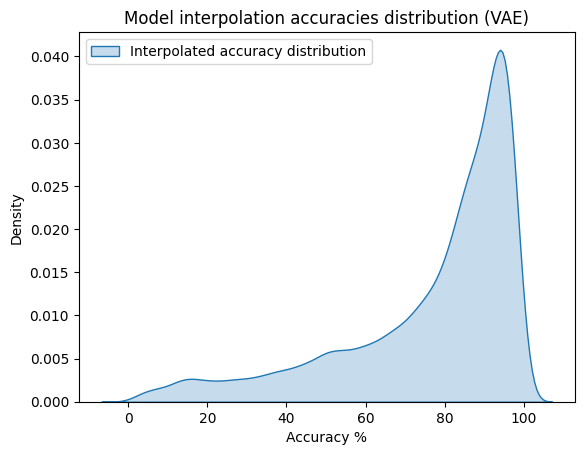

In [23]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []
bad_accuracy = []

for i in tqdm(range(0, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)

        latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))

        mean_1 = autoencoder.mu(latent_1)
        logvar_1 = autoencoder.logvar(latent_1)
        latent_1 = autoencoder.reparameterize(mean_1, logvar_1)

        mean_2 = autoencoder.mu(latent_2)
        logvar_2 = autoencoder.logvar(latent_2)
        latent_2 = autoencoder.reparameterize(mean_2, logvar_2)

        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = autoencoder.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        # if(accuracy < 50):
        #     print(i)
        #     print(i+1)
        #     print(j)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model interpolation accuracies distribution (VAE)")
plt.xlabel("Accuracy %")
plt.show()

In [7]:
def plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha):
    parameters_1, angle_1 = datapoint_1
    parameters_2, angle_2 = datapoint_2

    parameters_1 = parameters_1.unsqueeze(0)
    parameters_2 = parameters_2.unsqueeze(0)

    latent_1 = model.encoder(parameters_1)
    latent_2 = model.encoder(parameters_2)

    latent = (1-alpha)*latent_1 + alpha*latent_2

    mean = model.mu(latent)
    logvar = model.logvar(latent)
    latent = model.reparameterize(mean, logvar)
    w = model.decoder(latent).squeeze()

    angle = (1-alpha)*angle_1 + alpha*angle_2
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float()

    plot_decision_boundary(w, X_rotated, y)

In [8]:
autoencoder = VAE(latent_dim)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/eight_angles_small.csv")

X, y = get_moons_dataset()

alpha = 0.8
index_1 = 38454
index_2 = 48454

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]

interact(plot_interpolation, model=fixed(autoencoder), datapoint_1=fixed(datapoint_1), datapoint_2=fixed(datapoint_2), X=fixed(X), y=fixed(y), alpha=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

<function __main__.plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha)>

(8000, 2)


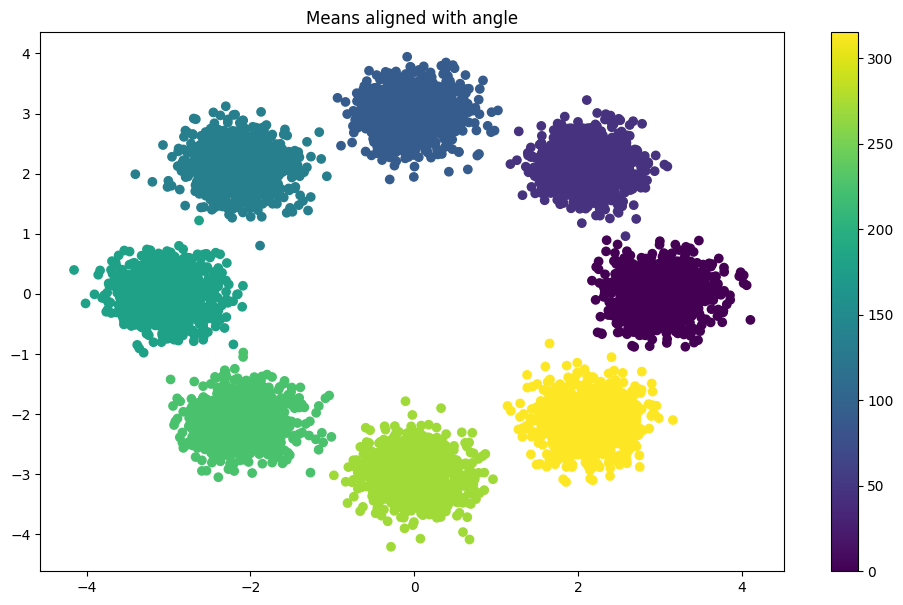

In [54]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Define the angles in degrees
angles = np.arange(0, 360, 45)

c = []
for angle in angles:
    c.append([angle]*1000)

# Convert angles to radians
angles_rad = np.deg2rad(angles)

# Calculate the means using sine and cosine, and scale them to make them farther apart
scale_factor = 3
means = np.array([(scale_factor * np.cos(angle), scale_factor * np.sin(angle)) for angle in angles_rad])

# Define the covariance matrix (identity matrix for simplicity)
cov = np.array([[0.1, 0], [0, 0.1]])

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()

# Plot the distributions as scatter plots

rv = multivariate_normal(means[0], cov)
points = rv.rvs(size=1000)

for mean in means[1:]:
    rv = multivariate_normal(mean, cov)
    samples = rv.rvs(size=1000)
    points = np.vstack((points, samples))

print(points.shape)
img = ax.scatter(points[:, 0], points[:, 1], c=c, cmap="viridis")
fig.colorbar(img)
plt.title("Means aligned with angle")
plt.show()
